In [1]:
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax
try:
    import flax
except ModuleNotFoundError:
    %pip install -qq flax
    import flax
try:
    import jaxopt
except ModuleNotFoundError:
    %pip install -qq jaxopt
    import jaxopt
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import jit
import flax.linen as nn
from flax.training import train_state
import tensorflow_probability.substrates.jax as tfp
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf
import seaborn as sns
from models import mlp, gmlp
from datasets import regression_data
from utility import utils

2022-06-13 13:51:07.259003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


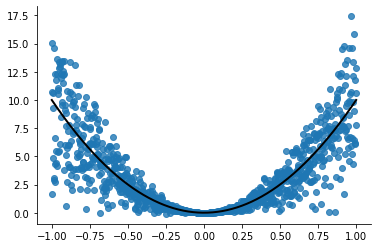

In [2]:
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X,Y,y_true = regression_data.data(points=1000, xrange=(-3,3), std=4) 
plt.figure() 
plt.scatter(X, Y,alpha=0.8)
plt.plot(X ,y_true, linewidth=2,color='black',linestyle='-')
sns.despine()

In [3]:
model = mlp.mlp([32 ,64, 1])

In [4]:
def fit(model, params, X, y, learning_rate = 0.01, epochs=100, key=0, verbose=False):
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

    loss_grad_fn = jax.jit(jax.value_and_grad(model.loss_fn))
    key = jax.random.PRNGKey(key)
    losses = []
    for i in range(epochs):
        key, _ = jax.random.split(key)
        loss_val, grads = loss_grad_fn(params, X, y)
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        losses.append(loss_val)
        if verbose and i % (epochs / 10) == 0:
            print('Loss step {}: '.format(i), loss_val)
    return params, jnp.array(losses)

In [5]:
n_estimators = 10
x_grid = jnp.linspace(-2,2,1000).reshape(-1,1)
keys = jax.random.split(jax.random.PRNGKey(0),n_estimators)
Y_final = []
parameters=[]
for i in range(n_estimators):
  ids = jax.random.choice(keys[i], jnp.array(range(1000)), (1000,1))
  x, y = X[ids], Y[ids]
  loss = []
  params = model.init(keys[i], x, True)
  params,losses = utils.fit(model, params,{ "X" : x, "y":y},  epochs=100)
  Y_pred = model.apply(params, x_grid, True)
  parameters.append(params)
  Y_final.append(Y_pred)

In [6]:
Y_final = jnp.array(Y_final)
mean = Y_final.mean(axis=0)
std = Y_final.std(axis=0)
mean=mean.squeeze()
std=std.squeeze()

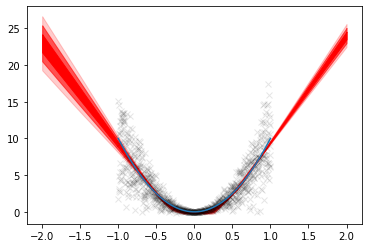

In [7]:
plt.plot(X,Y,'kx',alpha=0.1)
plt.fill_between(x_grid.squeeze(),mean+std,mean-std,color='red',alpha=1)
plt.fill_between(x_grid.squeeze(),mean+2*std,mean-2*std,color='red',alpha=0.6)
plt.fill_between(x_grid.squeeze(),mean+3*std,mean-3*std,color='red',alpha=0.2)
plt.plot(X,10*X*X)

In [8]:
model = gmlp.gmlp([32 , 64, 32])

In [9]:
n_estimators = 10
x_grid = jnp.linspace(-2,2,1000).reshape(-1,1)
keys = jax.random.split(jax.random.PRNGKey(0),n_estimators)
Y_final = []
parameters=[]
for i in range(n_estimators):
  ids = jax.random.choice(keys[i], jnp.array(range(1000)), (1000,1))
  x, y = X[ids].reshape(-1,1), Y[ids].reshape(-1,1)
  loss = []
  params = model.init(keys[i], x)
  params,losses = utils.fit(model, params, { "X" : x, "y":y},  epochs=100)
  Y_pred = model.apply(params, x_grid)
  parameters.append(params)
  Y_final.append(Y_pred)

In [10]:
Y_final = jnp.array(Y_final)
means_ = Y_final[:,:,0]
sigmas_ = Y_final[:,:,1]
mean = means_.mean(axis=0)
sigma = (sigmas_ + means_**2).mean(axis=0) - mean**2

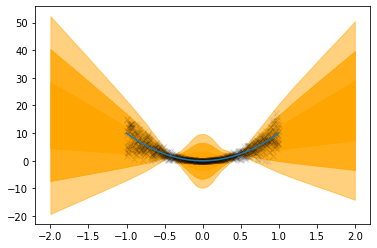

In [11]:
plt.plot(X,Y,'kx',alpha=0.1)
plt.fill_between(x_grid.squeeze(),mean+sigma,mean-sigma,color='orange',alpha=1)
plt.fill_between(x_grid.squeeze(),mean+2*sigma,mean-2*sigma,color='orange',alpha=0.8)
plt.fill_between(x_grid.squeeze(),mean+3*sigma,mean-3*sigma,color='orange',alpha=0.5)
plt.plot(X,10*X*X)